# **Aplicación de una Red Neuronal Profunda para Clasificación de Imágenes**  


Utilizarás las funciones que implementaste en cuaderno anterior para construir una **red neuronal profunda** y aplicarla a la clasificación de **gatos vs no-gatos**. Con suerte, verás una **mejora en la precisión** en comparación con tu implementación previa de **regresión logística**.  

**Después de esta tarea, serás capaz de:**  
✅ Construir y aplicar una **red neuronal profunda** para **aprendizaje supervisado**.  



## **1 - Paquetes**

Primero, importemos todos los paquetes que necesitarás durante esta asignación.  

- [**numpy**](www.numpy.org) es el paquete fundamental para la computación científica con Python.  
- [**matplotlib**](http://matplotlib.org) es una biblioteca para graficar en Python.  
- [**h5py**](http://www.h5py.org) es un paquete común para interactuar con conjuntos de datos almacenados en un archivo **H5**.  
- [**PIL**](http://www.pythonware.com/products/pil/) y [**scipy**](https://www.scipy.org/) se utilizan aquí para probar tu modelo con tu propia imagen al final.  
- **dnn_app_utils** proporciona las funciones implementadas en el cuaderno *"Construyendo una DNN"*.  
- `np.random.seed(1)` se usa para mantener consistentes todas las llamadas a funciones aleatorias. Esto nos ayudará a calificar tu trabajo.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from dnn_app_utils_v2 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## **2 - Conjunto de Datos**  

Usarás el mismo conjunto de datos **"Gato vs No-Gato"** que en la asignación **"Regresión Logística como intro a las ANN"**. En ese modelo se logró un **70% de precisión en el conjunto de prueba** para clasificar imágenes de gatos vs no-gatos. ¡Esperamos que tu nuevo modelo tenga un mejor resultado!  

**Enunciado del Problema**:  
Se te proporciona un conjunto de datos (`data.h5`) que contiene:  
- Un **conjunto de entrenamiento** con $ m_{train} $ imágenes etiquetadas como **gato (1)** o **no-gato (0)**.  
- Un **conjunto de prueba** con $ m_{test} $ imágenes etiquetadas como **gato (1)** o **no-gato (0)**.  
- Cada imagen tiene la forma **(num_px, num_px, 3)**, donde **3** corresponde a los **tres canales de color (RGB)**.  

Vamos a familiarizarnos más con el conjunto de datos. **Carga los datos ejecutando la celda a continuación.** 

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

El siguiente código mostrará una imagen del conjunto de datos. Siéntete libre de cambiar el índice y volver a ejecutar la celda varias veces para ver otras imágenes. 

y = 0. It's a non-cat picture.


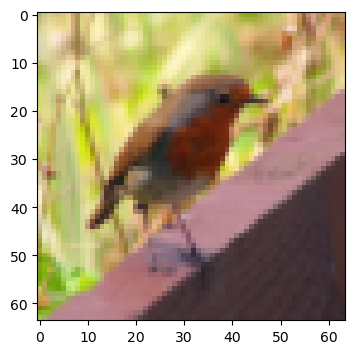

In [3]:
# Ejemplo
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [4]:
# Explorar el dataset
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


Como de costumbre, debes **redimensionar** y **normalizar** las imágenes antes de ingresarlas a la red neuronal. El código para hacerlo se encuentra en la celda siguiente.


In [5]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$ es $64 \times 64 \times 3$ es el tamaño del vector de entrada.

## **3 - Arquitectura del modelo**

Ahora que estás familiarizado con el conjunto de datos, es momento de construir una **red neuronal profunda** para diferenciar imágenes de gatos de imágenes que no son de gatos.

Vamos a definir uan arquitectura de red flexible y la usaremos para construir **dos modelos diferentes**:
- Una **red neuronal de 2 capas**.
- Una **red neuronal profunda de $L$ capas**.

Luego, compararás el rendimiento de estos modelos y probarás diferentes valores para $L$.

Veamos las dos arquitecturas.

---

## **3.1 - Red Neuronal de 2 Capas**

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">

<caption><center> <u>Figura 2</u>: Red neuronal de 2 capas. <br> El modelo se resume como:  
***ENTRADA -> LINEAR -> RELU -> LINEAR -> SIGMOIDE -> SALIDA***. </center></caption>

<u>**Arquitectura detallada de la Figura 2**</u>:
- La entrada es una imagen de **(64,64,3)** que se aplana a un vector de tamaño $ (12288,1) $.
- El vector correspondiente $ [x_0, x_1, ..., x_{12287}]^T $ se multiplica por la matriz de pesos $ W^{[1]} $ de tamaño $ (n^{[1]}, 12288) $.
- Luego, se agrega un término de sesgo y se aplica la **ReLU**, obteniendo el vector:  
  $$
  [a_0^{[1]}, a_1^{[1]}, ..., a_{n^{[1]}-1}^{[1]}]^T
  $$
- Se repite el mismo proceso.
- Se multiplica el vector resultante por $ W^{[2]} $ y se agrega el sesgo.
- Finalmente, se aplica la función **sigmoide**. Si el resultado es **mayor que 0.5**, la imagen se clasifica como un gato.

---

## **3.2 - Red Neuronal Profunda de $L$ Capas**

Es difícil representar una red neuronal profunda de $ L $ capas con la representación anterior. Sin embargo, aquí tienes una representación simplificada:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">

<caption><center> <u>Figura 3</u>: Red neuronal de $ L $ capas. <br> El modelo se resume como:  
***[LINEAR -> RELU] $ \times (L-1) $ -> LINEAR -> SIGMOIDE***. </center></caption>

<u>**Arquitectura detallada de la Figura 3**</u>:
- La entrada es una imagen de **(64,64,3)** que se aplana a un vector de tamaño $ (12288,1) $.
- El vector correspondiente $ [x_0, x_1, ..., x_{12287}]^T $ se multiplica por la matriz de pesos $ W^{[1]} $ y se agrega el sesgo $ b^{[1]} $.  
  - El resultado se denomina **unidad lineal**.
- Luego, se aplica la **ReLU** a la unidad lineal.  
  - Este proceso se repite varias veces para cada **$ (W^{[l]}, b^{[l]}) $**, dependiendo de la arquitectura del modelo.
- Finalmente, se aplica la **función sigmoide** a la última unidad lineal.  
  - Si el resultado es **mayor que 0.5**, la imagen se clasifica como un gato.

---

# **4 - Metodología General**

Como de costumbre, seguirás la metodología de **Deep Learning** para construir el modelo:

1. **Inicializar los parámetros / Definir los hiperparámetros**.
2. **Iterar por `num_iterations`**:
   - a. **Propagación hacia adelante**.
   - b. **Cálculo de la función de costo**.
   - c. **Propagación hacia atrás**.
   - d. **Actualizar los parámetros** (usando los parámetros y gradientes obtenidos en la retropropagación).
3. **Usar los parámetros entrenados para predecir las etiquetas**.


  
Usa las funciones auxiliares que implementaste anteriormente para construir una **red neuronal de $ L $ capas** con la siguiente estructura:  

$$
[\text{LINEAR} \to \text{RELU}] \times (L-1) \to \text{LINEAR} \to \text{SIGMOID}
$$

Las funciones que podrías necesitar y sus entradas son:  

```python
def initialize_parameters_deep(layer_dims):
    ...
    return parameters 

def L_model_forward(X, parameters):
    ...
    return AL, caches

def compute_cost(AL, Y):
    ...
    return cost

def L_model_backward(AL, Y, caches):
    ...
    return grads

def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [6]:
# FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters


# **5 - Redes**

## **5.1 - Red neuronal de dos capas**


Usa el modelo anterior para definir y entrenar una red de 2 capas, incluyendo una capa oculta de 7 neuronas

Define las dimensiones:

Cost after iteration 0: 0.695046
Cost after iteration 100: 0.570120
Cost after iteration 200: 0.468086
Cost after iteration 300: 0.436066
Cost after iteration 400: 0.409335
Cost after iteration 500: 0.375641
Cost after iteration 600: 0.309665
Cost after iteration 700: 0.282614
Cost after iteration 800: 0.238729
Cost after iteration 900: 0.140842
Cost after iteration 1000: 0.110362
Cost after iteration 1100: 0.086423
Cost after iteration 1200: 0.069959
Cost after iteration 1300: 0.058394
Cost after iteration 1400: 0.049966
Cost after iteration 1500: 0.043448
Cost after iteration 1600: 0.038340
Cost after iteration 1700: 0.034280
Cost after iteration 1800: 0.030721
Cost after iteration 1900: 0.027541
Cost after iteration 2000: 0.024747
Cost after iteration 2100: 0.022269
Cost after iteration 2200: 0.020051
Cost after iteration 2300: 0.018115
Cost after iteration 2400: 0.016420


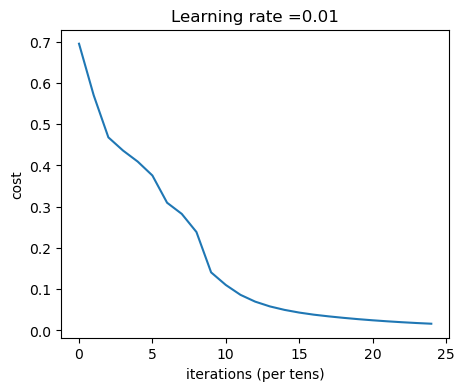

In [7]:
layers_dims = [12288, 7, 1] #  3-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True, learning_rate = 0.01)

In [8]:
pred_train = predict(train_x, train_y, parameters)
pred_test = predict(test_x, test_y, parameters)


Accuracy: 0.9999999999999998
Accuracy: 0.76


¡Felicidades!

Parece que tu **red neuronal de 2 capas** tiene un **mejor rendimiento (76%)** en comparación con la implementación de **regresión logística (68%)**.  

## **5.2 - Red neuronal de L capas**

Veamos si puedes obtener **aún mejores resultados** con un modelo de **$ L $ capas**.

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


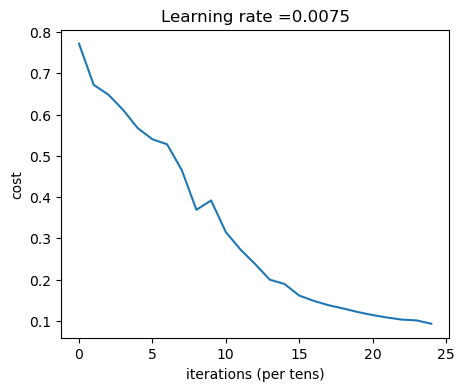

In [9]:
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

**Salida esperada**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.092878 </td>
    </tr>
</table>

In [10]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


<table>
    <tr>
    <td>
    **Train Accuracy**
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [11]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


**Salida esperada**:

<table> 
    <tr>
        <td> **Test Accuracy**</td>
        <td> 0.8 </td>
    </tr>
</table>

¡Felicidades!

Parece que tu **red neuronal de 5 capas** ha logrado un **mejor rendimiento (80%)** en comparación con tu **red neuronal de 2 capas (76%)** en el mismo conjunto de prueba.  

Este es un **buen resultado** para esta tarea. ¡Gran trabajo!

Sin embargo, cuando veamos como mejorando Redes Neuronales Profundas, veremos como se puede obtener una precisión aún mayor mediante una búsqueda sistemática de **mejores hiperparámetros**, como:  
- **Tasa de aprendizaje (`learning_rate`)**  
- **Dimensiones de las capas (`layers_dims`)**  
- **Número de iteraciones (`num_iterations`)**  
- Y otros conceptos avanzados.  



## **6 - Análisis de Resultados**  

Primero, echemos un vistazo a algunas imágenes que el **modelo de $L$ capas** etiquetó incorrectamente.  

Esto nos permitirá ver algunos ejemplos de imágenes mal clasificadas.

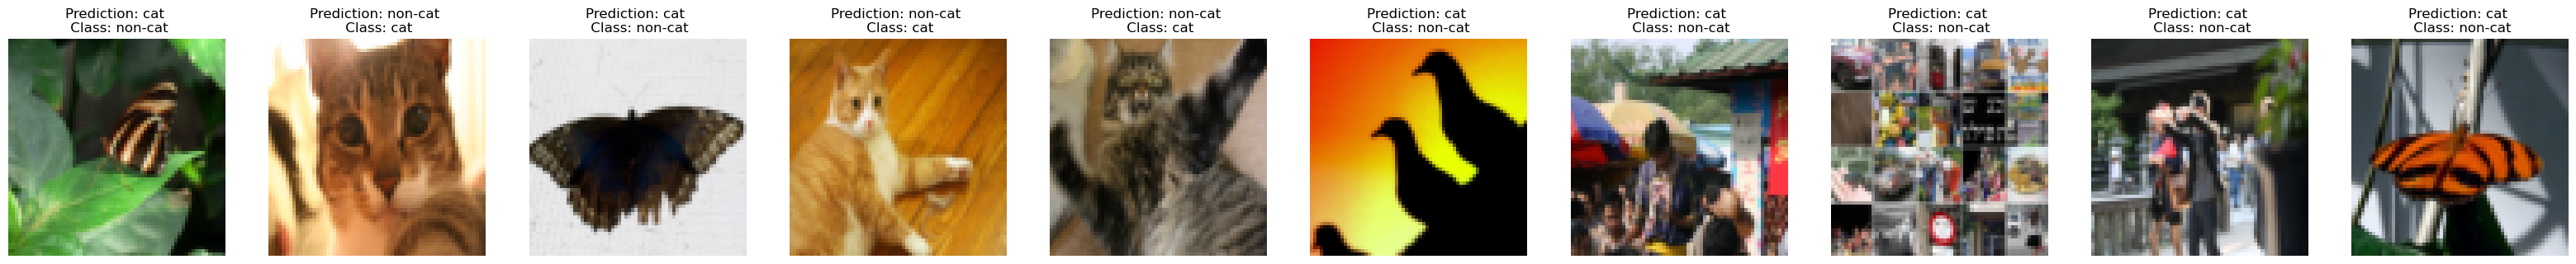

In [12]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**Algunos tipos de imágenes en las que el modelo tiende a tener un bajo rendimiento incluyen:**  
- El cuerpo del gato en una **posición inusual**.  
- El gato aparece sobre un **fondo de color similar**.  
- **Colores o especies de gatos inusuales**.  
- **Ángulo de la cámara**.  
- **Brillo de la imagen**.  
- **Variación de escala** (el gato es **muy grande o muy pequeño** en la imagen).

**References**:

- for auto-reloading external module: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython